# Introduction

This is a generative deep learning project that will utiluze a generative adversarial network (GAN). The goal of the project is to learn Monet's style from a set of his paintings and then apply his style to photos or create new photos in his style. 

Generative deep learning models are a type of unsupervised deep learning. It is generative because it generates "new" images, and is unsupervised because the input images do not have labels. The model will learn a latent structure from the training set, and then it can generate images based on what it has learned. It will not create the same exact images as it has seen. There are many different types of generative models and they all work in different ways and include different model constructions. 

In this project we will work with two different types of generative models. First we will use a deep convolutional generative adversarial network (DCGAN) and then we will use a cycle-consitent adversarial network (CycleGAN).

A lot of the code is based off of the [tutorial](https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial/notebook), which is wonderful! 

# Data
The dataset comes from Kaggle at this link: https://www.kaggle.com/competitions/gan-getting-started/overview

The data includes 300 Monet images, and 7,028 photos. The images are available in JPEG or TFRecord formats. We will use the TFRecord format. The Monet images will be used to train the model. Then the other photos can be used to tranform into Monet style or new images can be created from scratch.

We will look into more details of the data below:

In [1]:
#import needed libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
from keras import backend as K
from kaggle_datasets import KaggleDatasets

from glob import glob
import cv2
import os
import time
from PIL import Image
import PIL

import matplotlib.pyplot as plt
import numpy as np

import shutil

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [2]:
#Get TPU, if using
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE
    
print(tf.__version__)

Number of replicas: 1
2.12.0


In [3]:
#set file path variables
monet_path_jpg = '../input/gan-getting-started/monet_jpg/'
photo_path_jpg = '../input/gan-getting-started/photo_jpg/'
monet_path_tfrec = '../input/gan-getting-started/monet_tfrec/'
photo_path_tfrec = '../input/gan-getting-started/photo_tfrec/'

In [4]:
#check the quantity of train and test images and the size of an image
print("The number of Monet samples: ", len(os.listdir(monet_path_jpg)))
print("The number of photo samples: ", len(os.listdir(photo_path_jpg)))

# get image
filepath = monet_path_jpg + "000c1e3bff.jpg"
filepath2 = photo_path_jpg + "00068bc07f.jpg"
img = cv2.imread(filepath, cv2.IMREAD_ANYCOLOR)
img2 = cv2.imread(filepath2, cv2.IMREAD_ANYCOLOR)
  
# get width and height
imgshape = img.shape
imgshape2 = img2.shape
sameshape = (imgshape == imgshape)

# display width and height
print("The height of the image is: ", imgshape[0])
print("The width of the image is: ", imgshape[1])
print("The depth of the image is: ", imgshape[2])
print("Are the Monet and Photo images the same shape: ", sameshape)

The number of Monet samples:  300
The number of photo samples:  7038
The height of the image is:  256
The width of the image is:  256
The depth of the image is:  3
Are the Monet and Photo images the same shape:  True


The are 300 Monet images and 7,038 photos. All the images are 256x256x3, with 3 as the channel since they are RGB.


The code below is from the tutorial to load in the images.

In [5]:
#get path
GCS_PATH = KaggleDatasets().get_gcs_path()

#get all the filenames for monet paintings
MONET_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/monet_tfrec/*.tfrec'))
print('Monet TFRecord Files:', len(MONET_FILENAMES))

#get all filenames for photos
PHOTO_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/photo_tfrec/*.tfrec'))
print('Photo TFRecord Files:', len(PHOTO_FILENAMES))

Monet TFRecord Files: 5
Photo TFRecord Files: 20


# Data Loading and Cleaning

We will now load the data in. Since the data is images, there is not much cleaning we will do. The only cleaning step we will perform is to normalize the pixel values from (0,255) to (-1,1).

There are other image transformations that we could do to create more data/images, like rotating, flipping, blurring, among others. However, since this is my first time through a GAN, I'm going to try to keep it simple. 

In [6]:
#This code mostly comes from the tutorial
#set image size
IMAGE_SIZE = [256, 256]

def decode_image(image):
    #decode the image using tensorflow
    image = tf.image.decode_jpeg(image, channels=3)
    #normalize between -1 and 1
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_tfrecord(example):
    #only need image, don't need name or target
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

def load_dataset(filenames, labeled=True, ordered=False):
    # load the dataset
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

In [7]:
#use the above functions to load the datasets
monet_ds = load_dataset(MONET_FILENAMES, labeled=True).batch(1)
photo_ds = load_dataset(PHOTO_FILENAMES, labeled=True).batch(1)

Let's  visualize some examples of Monets and the other photos:

Examples of Monet: 


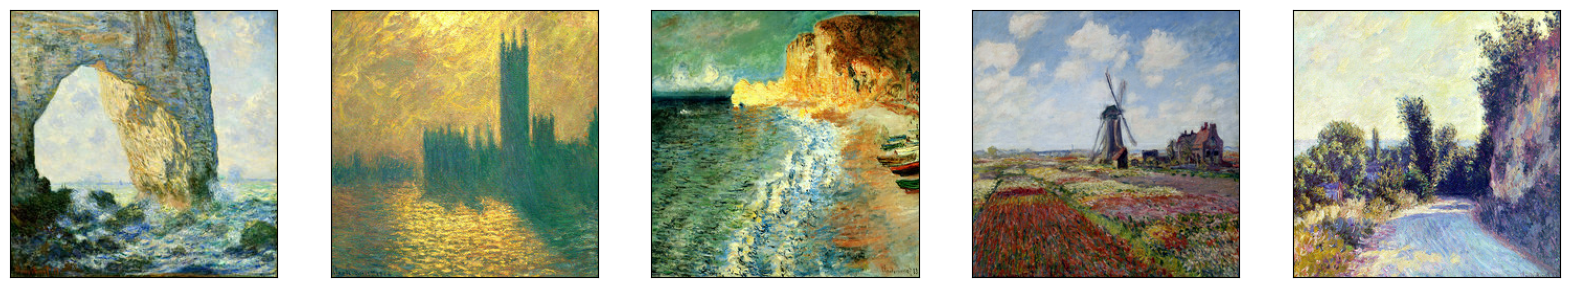

Examples of Photo: 


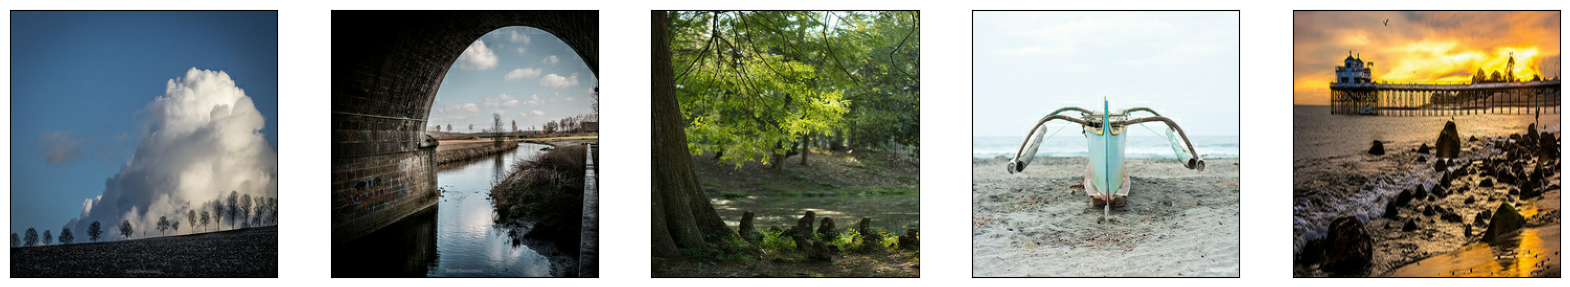

In [8]:
#turn datasets into iterables to plot them
example_monets = iter(monet_ds)
example_photos = iter(photo_ds)

#have list describing pictures
plt_titles = ['Monet', 'Photo']

#initialize variable to 0
j=0

#loop through both monet and photo examples
for ex_photo in [example_monets, example_photos]:
    #print what photos are being shown
    print('Examples of ' + plt_titles[j] + ': ')
    #make subplot
    fig, axs = plt.subplots(1, 5, figsize=(20,20))
    #loop through subplot axes
    for i, ax in enumerate(fig.axes):
        #plt the next image in iterable
        ax.imshow(next(ex_photo)[0] * 0.5 + 0.5)
        #remove tick marks
        ax.set(xticks=[], yticks=[])   
    #increment variable
    j += 1
    #show subplots
    plt.show()

There is a noticeable difference between Monet and the photos. 

The plan will be to trial two different GAN models:
1. DCGAN model.
2. CycleGAN model

We will start with DCGAN.


# DCGAN
We will utilize a keras [tutorial](https://keras.io/examples/generative/dcgan_overriding_train_step/) and a [kaggle notebook](https://www.kaggle.com/code/jesperdramsch/getting-started-with-standard-gans-tutorial) on DCGAN to help build our model. 

A deep convolutional GAN utilizes convolutional and convolutional-tranpose layers for the discriminator and generator. The generator creates the image from a latent vector. This will be a random vector in our code below.

I'm trying this one because from the tutorials this model should work well to learn from the training set. Then it should be able to easily generate images from random numbers in the latent space. This seems like a fairly easy model that should work at least decently. 

In [9]:
#images are all 256x256x3
original_dim = 256

#create discrimator
discriminator = keras.Sequential(
    [
        #set input to model
        keras.Input(shape=(original_dim,original_dim,3)),
        #convulotional layer with 64 filters
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        #add batch normalization
        layers.BatchNormalization(),
        #add leakyReLU activation
        layers.LeakyReLU(alpha=0.2),
        #continue to add conv2D and Leaky layers
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        #add 2 more layers (than keras tutorial) to bring down to 8x8 
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        #flatten the model to 1d
        layers.Flatten(),
        layers.Dropout(0.2),
        #last layer of 1 to discriminate to yes or no
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)
#print summary
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      3136      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 64)     256       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 128, 128, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 128)       131200    
                                                                 
 batch_normalization_1 (Batc  (None, 64, 64, 128)      512       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 64, 64, 128)     

In [10]:
latent_dim = 128
#create generator
generator = keras.Sequential(
    [
        #input to generator is latent dim
        keras.Input(shape=(latent_dim,)),
        #add dense layer 
        layers.Dense(8 * 8 * 128),
        #reshape to 8x8x128
        layers.Reshape((8, 8, 128)),
        #conv2d transpose which is opposite of conv2d
        #convultional layer used in above for discriminator
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        layers.BatchNormalization(),
        #add leaky relu activation
        layers.LeakyReLU(alpha=0.2),
        #repeat conv2dtranspose and relu layers until 256x256x512
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        #add two more layers (compared to Keras tutorial) to get to 256x256
        layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        #add conv2d layer to get to 256x256x3
        layers.Conv2D(3, kernel_size=5, padding="same", activation="tanh"),
    ],
    name="generator",
)
#print summary
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 8192)              1056768   
                                                                 
 reshape (Reshape)           (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 128)      262272    
 nspose)                                                         
                                                                 
 batch_normalization_5 (Batc  (None, 16, 16, 128)      512       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 32, 32, 256)      52

In [11]:
#this was with help from kaggle notebook
#use strategy scope for use with TPU to speed things up 
with strategy.scope():
    #define discriminator loss
    def discriminator_loss(predictions_real, predictions_gen, labels_real):
        gen_loss  = tf.reduce_mean((predictions_gen  - tf.reduce_mean(predictions_real) + labels_real) ** 2)
        real_loss = tf.reduce_mean((predictions_real - tf.reduce_mean(predictions_gen)  - labels_real) ** 2)
        return (gen_loss + real_loss) / 2
    
    #define generator loadd
    def generator_loss(predictions_real, predictions_gen, labels_real):
        gen_loss  = tf.reduce_mean((predictions_gen  - tf.reduce_mean(predictions_real) - labels_real) ** 2)
        real_loss = tf.reduce_mean((predictions_real - tf.reduce_mean(predictions_gen)  + labels_real) ** 2)
        return (gen_loss + real_loss) / 2

In [12]:
#this was with help from kaggle notebook and keras tutorial
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim, real_label=0.5, fake_label=0):
        super().__init__()
        #set all variables in init
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.real_label = real_label
        self.fake_label = fake_label

    def compile(self, d_optimizer, g_optimizer, d_loss_fn, g_loss_fn):
        #compile model with optimizers and loss functions
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        #self.loss_fn = loss_fn
        self.d_loss_fn = d_loss_fn
        self.g_loss_fn = g_loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        if isinstance(real_images, tuple):
            real_images = real_images[0]
        
        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)
        
        #set labels
        labels_gen  = tf.zeros((batch_size, 1)) + self.fake_label
        labels_real = tf.zeros((batch_size, 1)) + self.real_label
        
        # Add random noise to the labels - important trick!
        labels_gen  += 0.05 * tf.random.uniform(tf.shape(labels_gen))
        labels_real += 0.05 * tf.random.uniform(tf.shape(labels_real))

        # Train the discriminator
        with tf.GradientTape() as tape:
            #generate images
            images_gen = self.generator(random_latent_vectors, training=False)
            
            # Train the discriminator
            predictions_real = self.discriminator(real_images, training=True)
            predictions_gen  = self.discriminator(images_gen, training=True)
            #get discriminator loss
            d_loss = self.d_loss_fn(predictions_real, predictions_gen, labels_real)
        
        #apply gradients
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator
        with tf.GradientTape() as tape:
            # Train the generator
            images_gen = self.generator(random_latent_vectors, training=True)
            
            #get results from discriminator, don't train
            predictions_real = self.discriminator(real_images, training=False)
            predictions_gen  = self.discriminator(images_gen, training=False)
            
            #get generator loss
            g_loss = self.g_loss_fn(predictions_real, predictions_gen, labels_real)
            
        #get gradients and apply
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

In [13]:
class GANMonitor(keras.callbacks.Callback):
    #define gan monitor
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        #get random vector to generate with
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        #generate image
        generated_images = self.model.generator(random_latent_vectors)
        #get pixel values back to 0 to 255
        generated_images = (generated_images + 1)*127.5
        generated_images.numpy()
        #save the images
        for i in range(self.num_img):
            img = keras.utils.array_to_img(generated_images[i])
            img.save("generated_img_%03d_%d.png" % (epoch, i))

In [14]:
epochs = 100  # In practice, use ~100 epochs

#define GAN and compile
gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0005),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0005),
    d_loss_fn=discriminator_loss,
    g_loss_fn=generator_loss
)

#fit GAN model
gan.fit(monet_ds, epochs=epochs, callbacks=[GANMonitor(num_img=1, latent_dim=latent_dim)])

Epoch 1/100
300/300 [==============================] - 69s 164ms/step - d_loss: 0.1486 - g_loss: 0.1917
Epoch 2/100
300/300 [==============================] - 49s 164ms/step - d_loss: 0.0950 - g_loss: 0.2734
Epoch 3/100
300/300 [==============================] - 49s 163ms/step - d_loss: 0.0281 - g_loss: 0.2512
Epoch 4/100
300/300 [==============================] - 50s 164ms/step - d_loss: 0.0261 - g_loss: 0.2296
Epoch 5/100
300/300 [==============================] - 49s 163ms/step - d_loss: 0.0266 - g_loss: 0.2757
Epoch 6/100
300/300 [==============================] - 49s 163ms/step - d_loss: 0.0158 - g_loss: 0.2723
Epoch 7/100
300/300 [==============================] - 49s 163ms/step - d_loss: 0.0167 - g_loss: 0.2725
Epoch 8/100
300/300 [==============================] - 49s 163ms/step - d_loss: 0.0130 - g_loss: 0.2662
Epoch 9/100
300/300 [==============================] - 49s 164ms/step - d_loss: 0.0095 - g_loss: 0.2672
Epoch 10/100
300/300 [==============================] - 49s 163m

In [15]:
! mkdir ../images

In [16]:
#go through all photos and generate the Monets to submit
#i = 1
for i in range(8000):
    prediction = generator(np.random.randn(1, latent_dim), training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save("../images/" + str(i) + ".jpg")
    #i += 1

In [17]:
#make zip file of generated Monet's to submit
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")
#Kaggle score: 473

'/kaggle/working/images.zip'

# Results
Shown below are a generated image for every 5th epoch and 4 randomly generated images from our final model. 

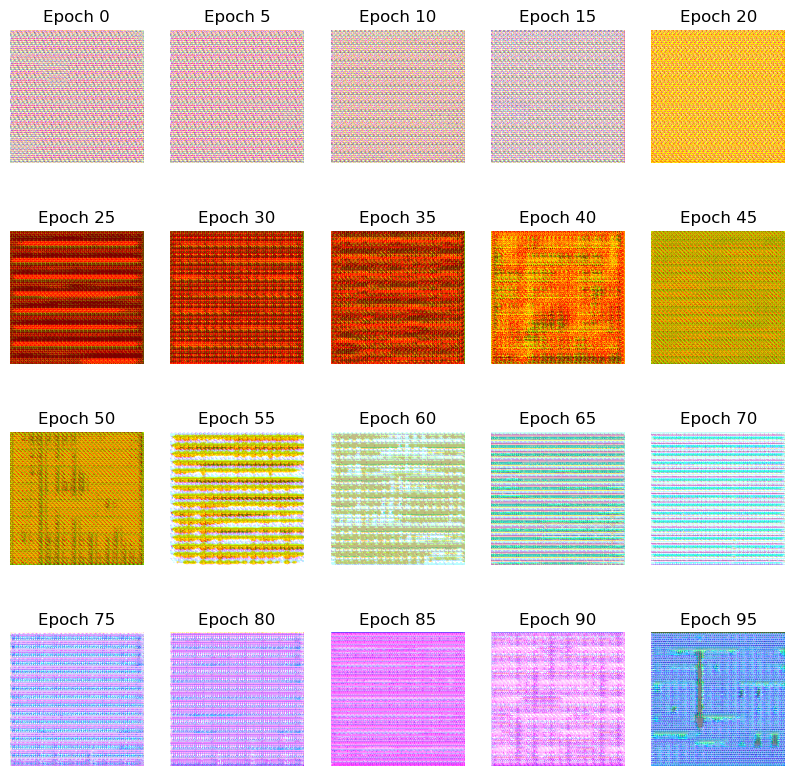

In [18]:
#initliaze subplots and variable
fig, axs = plt.subplots(4, 5, figsize=(10, 10))
j=0

#loop through axes
for i, ax in enumerate(fig.axes):
    #Show images 
    img = np.asarray(Image.open("generated_img_%03d_0.png" % (j)))
    ax.imshow(img)
    #set title and hide axes
    ax.set_title("Epoch " + str(j))
    ax.axis("off")
    #show every 5th epoch
    j += 5
plt.show()

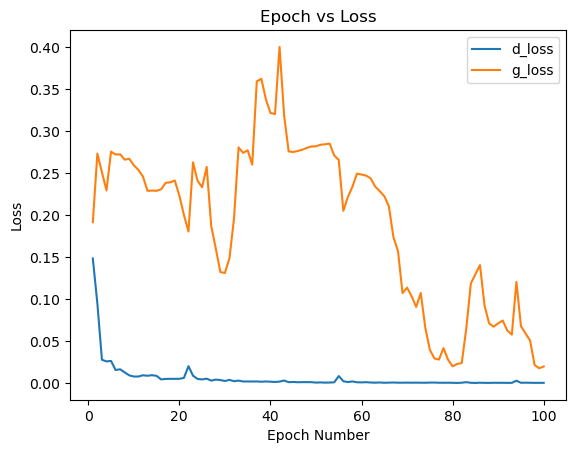

In [60]:
#make plots for loss over epochs
plt.plot(np.arange(1,len(gan.history.history['d_loss']) + 1),gan.history.history['d_loss'])
plt.plot(np.arange(1,len(gan.history.history['g_loss']) + 1),gan.history.history['g_loss'])

#add title, axes labels and legend
plt.title("Epoch vs Loss")
plt.ylabel("Loss")
plt.xlabel('Epoch Number')
plt.legend(['d_loss', 'g_loss'], loc='best')

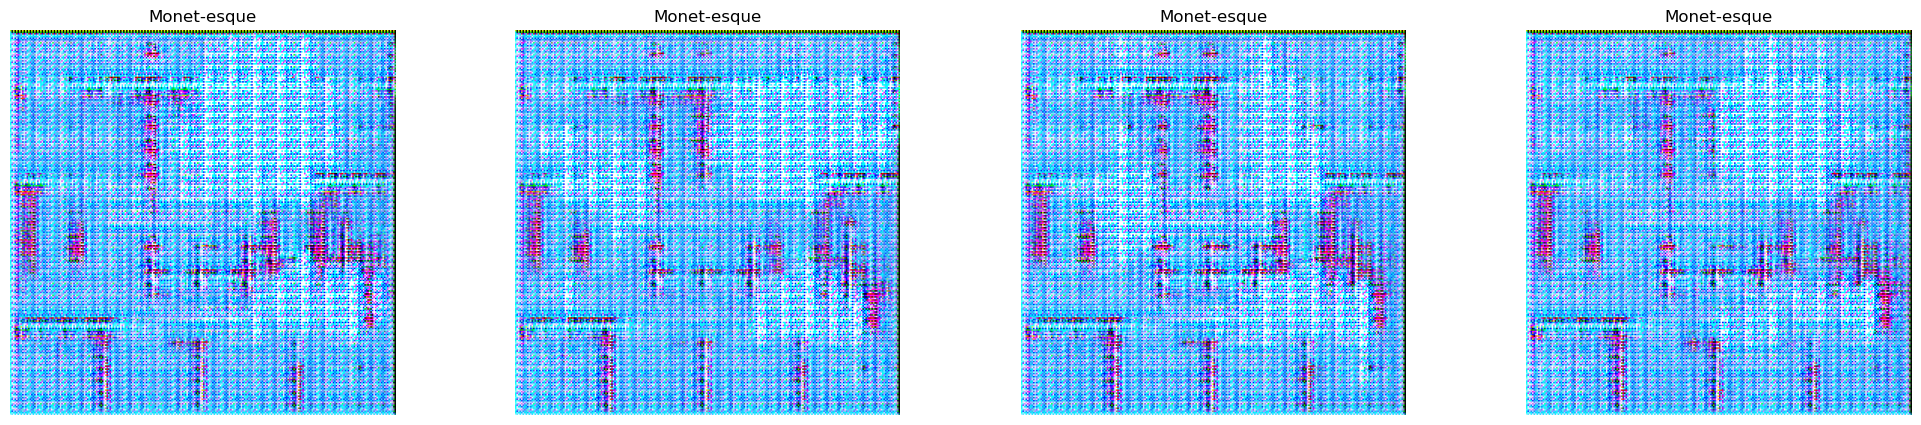

In [20]:
#show 4 genertated images from final model
_, ax = plt.subplots(1, 4, figsize=(25, 5))
for i in range(4):
    prediction = generator(np.random.randn(1, latent_dim), training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    
    ax[i].imshow(prediction)
    ax[i].set_title("Monet-esque")
    ax[i].axis("off")
plt.show()

The images change throughout the epochs, but it seems like mostly color changes. It does not seem to be making progress to looking more like a Monet. It could just need much more time to train (much higher number of epochs), but the model does not seem to be working well. All 4 images we generated from the final model look the same.

I would like to train and tune my model more to my own liking, but I don't have a large enough knowledge base on GANs yet. The class provided a decent introduction, but it is a very complex topic and I don't feel well equipped to change a bunch of options and tune the model. 

I plan to move to a cycle GAN model as it seems to be the most popular way to tackle on this competition. I have very little knowledge on Cycle GANs, but this seems like a great way to try to learn more and see if we can get some good results.

# CycleGAN

CycleGAN is a technique used for trainining unsupervised image-to-image translation models without paired examples. This seems ideal for this competition. For a cycleGAN you have a generator and a discriminator for both sets of images, the training set (the images you want to learn the style of), and the target set. You want to train the model on the training set and then apply the training set style to the target set. 

This technique works by generating the target images with the training generator, and then discriminating the real and fake ones. Then calculating the loss and gradients and using these to improve the models. You also generate the training images with the target generator and calculate the loss and gradients on those as well. You then continue cycling in this way to improve the model. 

I'm using this model because it is a little more adavanced, and takes the photo as inputs and applys the style it learns to it (in our case the Monet style). This should lead to some good results and most likely perform better than the DCGAN model. 

In [21]:
def discriminator_cgan(original_dim = 256):
    #make discriminator function for cgan for use 
    #for both monet and photo
    discriminator_cgan = keras.Sequential(
        [
            #set input
            keras.Input(shape=[original_dim,original_dim,3]),
            #add conv2d layer
            layers.Conv2D(64, kernel_size=4, strides=2, padding="same"), # (bs, 128, 128, 64)
            #add leaky relu activation
            layers.LeakyReLU(alpha=0.2),
            #continue adding these layers
            layers.Conv2D(128, kernel_size=4, strides=2, padding="same"), # (bs, 64, 64, 128)
            layers.LeakyReLU(alpha=0.2),
            layers.Conv2D(256, kernel_size=4, strides=2, padding="same"), # (bs, 32, 32, 256)
            layers.LeakyReLU(alpha=0.2),
            
            #add padding layer to increase 2 rows and 2 columns
            layers.ZeroPadding2D(), # (bs, 34, 34, 256)
            
            layers.Conv2D(512, 4, strides=1), # (bs, 31, 31, 512)
            layers.LeakyReLU(),
            #add padding layer to increase 2 rows and 2 columns
            layers.ZeroPadding2D(), # (bs, 33, 33, 512)
            #add last conv2d layer to get to 30x30x1
            layers.Conv2D(1, 4, strides=1), # (bs, 30, 30, 1)
        ],
        name="discriminator_cgan",
    )
    #discriminator_cgan.summary()
    
    return discriminator_cgan

In [22]:
#latent_dim = 128
def Generator_cgan(original_dim = 256):
    generator_cgan = keras.Sequential(
        [
            #first will take image in and down size to 1x1x256, then up size back to 256x256x3 for output
            #set input
            keras.Input(shape=[original_dim,original_dim,3]),
            #add conv2d layer
            layers.Conv2D(64, kernel_size=4, strides=2, padding="same"), # (bs, 128, 128, 64)
            #add leaky relu layer
            layers.LeakyReLU(alpha=0.2),
            #continue add these layers
            layers.Conv2D(128, kernel_size=4, strides=2, padding="same"), # (bs, 64, 64, 128)
            layers.LeakyReLU(alpha=0.2),
            layers.Conv2D(256, kernel_size=4, strides=2, padding="same"), # (bs, 32, 32, 256)
            layers.LeakyReLU(alpha=0.2),
            layers.Conv2D(256, kernel_size=4, strides=2, padding="same"), # (bs, 16, 16, 256)
            layers.LeakyReLU(alpha=0.2),
            layers.Conv2D(256, kernel_size=4, strides=2, padding="same"),# (bs, 8, 8, 256)
            layers.LeakyReLU(alpha=0.2),
            layers.Conv2D(256, kernel_size=4, strides=2, padding="same"), # (bs, 4, 4, 256)
            layers.LeakyReLU(alpha=0.2),
            layers.Conv2D(256, kernel_size=4, strides=2, padding="same"), # (bs, 2, 2, 256)
            layers.LeakyReLU(alpha=0.2),
            layers.Conv2D(256, kernel_size=4, strides=2, padding="same"), # (bs, 1, 1, 256)
            layers.LeakyReLU(alpha=0.2),

            #up size back to 256x256x3
            #add conv2dtranpose layer
            layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"), # (bs, 2, 2, 256)
            #add leaky relu layer
            layers.LeakyReLU(alpha=0.2),
            #continue adding layers
            layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"), # (bs, 4, 4, 256)
            layers.LeakyReLU(alpha=0.2),
            layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"), # (bs, 8, 8, 256)
            layers.LeakyReLU(alpha=0.2),
            layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"), # (bs, 16, 16, 256)
            layers.LeakyReLU(alpha=0.2),
            layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"), # (bs, 32, 32, 256)
            layers.LeakyReLU(alpha=0.2),
            layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"), # (bs, 64, 64, 128)
            layers.LeakyReLU(alpha=0.2),
            layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding="same"), # (bs, 128, 128, 64)
            layers.LeakyReLU(alpha=0.2),
            #add last conv2dtranspose to get to 256x256x3
            layers.Conv2DTranspose(3, kernel_size=4, strides=2, padding="same",
                                  activation='tanh'), # (bs, 256, 256, 3)
            
        ],
        name="generator_cgan",
    )
    #generator_cgan.summary()
    
    return generator_cgan

In [23]:
#use strategy.scope to use tpu if available
with strategy.scope():
    #initialie the generators
    monet_generator_cgan = Generator_cgan() # transforms photos to Monet-esque paintings
    photo_generator_cgan = Generator_cgan() # transforms Monet paintings to be more like photos
    
    #initiliaze the discriminators
    monet_discriminator_cgan = discriminator_cgan() # differentiates real Monet paintings and generated Monet paintings
    photo_discriminator_cgan = discriminator_cgan() # differentiates real photos and generated photos

In [24]:
#to_monet = monet_generator_cgan(next(example_photos)[0])

#plt.subplot(1, 2, 1)
#plt.title("Original Photo")
#plt.imshow(example_photo[0] * 0.5 + 0.5)

#plt.subplot(1, 2, 2)
#plt.title("Monet-esque Photo")
#plt.imshow(to_monet[0] * 0.5 + 0.5)
#plt.show()

In [25]:
# make a cyclegan class
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator_cgan,
        photo_generator_cgan,
        monet_discriminator_cgan,
        photo_discriminator_cgan,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        #set all self variables
        self.m_gen = monet_generator_cgan
        self.p_gen = photo_generator_cgan
        self.m_disc = monet_discriminator_cgan
        self.p_disc = photo_discriminator_cgan
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # generate fake monet from real photo, then use that
            #to generate the "real" photo back
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            #generate photo from monet, then use that
            #to generate monet back again
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

In [26]:
with strategy.scope():
    #define discriminator loss in strategy scope for tpu
    def discriminator_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)

        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)

        total_disc_loss = real_loss + generated_loss

        return total_disc_loss * 0.5

In [27]:
with strategy.scope():
    #define generator loss in strategy scope for tpu
    def generator_loss(generated):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

In [28]:
with strategy.scope():
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

        return LAMBDA * loss1

In [29]:
with strategy.scope():
    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss

In [30]:
with strategy.scope():
    #set optimizers
    monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [31]:
with strategy.scope():
    #create CycleGAN
    cycle_gan_model = CycleGan(
        monet_generator_cgan, photo_generator_cgan, monet_discriminator_cgan, photo_discriminator_cgan
    )
    
    #compile CycleGAN
    cycle_gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

In [32]:
class cycleGANMonitor(keras.callbacks.Callback):
    #def __init__(self): #, num_img=3): #, latent_dim=128):
        #self.num_img = num_img
        #self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        #Take image from dataset and generate for each epoch
        generated_images = self.model.m_gen(next(iter(photo_ds)), training=False)[0].numpy()
        img = (generated_images * 127.5 + 127.5).astype(np.uint8)
        im = PIL.Image.fromarray(img)
        #save image
        im.save("generated_img_%03d_1.png" % (epoch))
        

In [33]:
#fit model
cycle_gan_model.fit(tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=100, callbacks = [cycleGANMonitor()])

Epoch 1/100
300/300 [==============================] - 54s 115ms/step - monet_gen_loss: 13.4924 - photo_gen_loss: 13.5605 - monet_disc_loss: 0.4238 - photo_disc_loss: 0.4187
Epoch 2/100
300/300 [==============================] - 35s 115ms/step - monet_gen_loss: 12.9528 - photo_gen_loss: 12.8615 - monet_disc_loss: 0.4963 - photo_disc_loss: 0.5077
Epoch 3/100
300/300 [==============================] - 35s 115ms/step - monet_gen_loss: 12.6381 - photo_gen_loss: 12.7271 - monet_disc_loss: 0.5430 - photo_disc_loss: 0.5059
Epoch 4/100
300/300 [==============================] - 36s 115ms/step - monet_gen_loss: 12.3629 - photo_gen_loss: 12.4490 - monet_disc_loss: 0.5092 - photo_disc_loss: 0.5216
Epoch 5/100
300/300 [==============================] - 35s 115ms/step - monet_gen_loss: 12.5043 - photo_gen_loss: 12.7962 - monet_disc_loss: 0.4784 - photo_disc_loss: 0.4741
Epoch 6/100
300/300 [==============================] - 35s 115ms/step - monet_gen_loss: 12.2181 - photo_gen_loss: 12.1184 - monet_

# Results
Shown below are a Monet-generated image for every 5th epoch and 5 input photos and their paired Monet-generated image from our final model. 

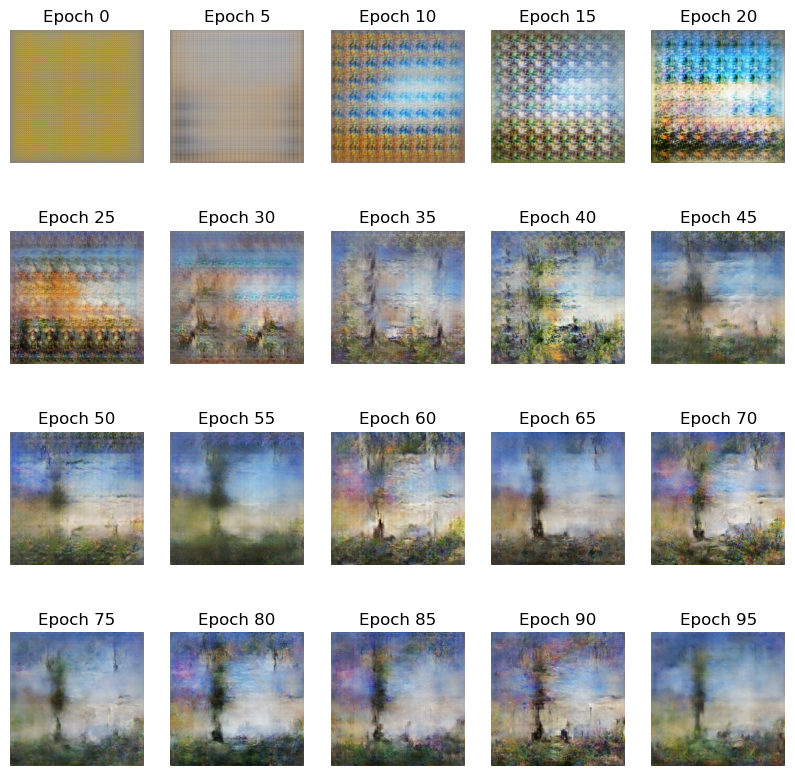

In [34]:
#initliaze subplots and variable
fig, axs = plt.subplots(4, 5, figsize=(10, 10))
j=0

#loop through axes
for i, ax in enumerate(fig.axes):
    #Show images 
    img = np.asarray(Image.open("generated_img_%03d_1.png" % (j)))
    ax.imshow(img)
    #set title and hide axes
    ax.set_title("Epoch " + str(j))
    ax.axis("off")
    #show every 5th epoch
    j += 5
plt.show()

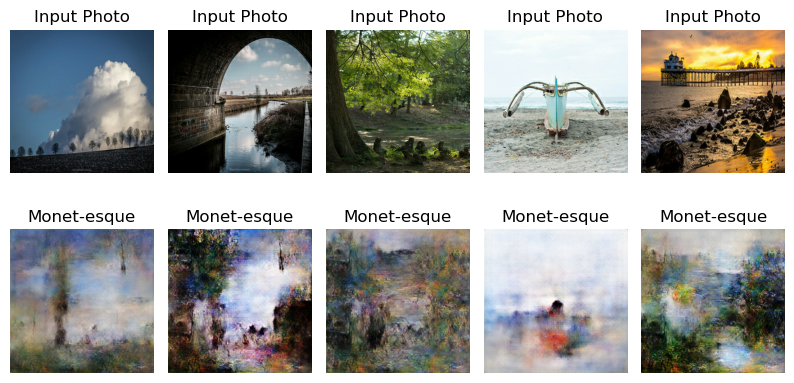

In [52]:
#initialize subplots
_, ax = plt.subplots(2, 5, figsize=(10, 10))
#loop through 5 images from dataset
for i, img in enumerate(photo_ds.take(5)):
    #use monet generator on the photos 
    prediction = monet_generator_cgan(img, training=False)[0].numpy()
    #transform to image that can be shown in python
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)
    
    #show image
    ax[0, i].imshow(img)
    ax[1, i].imshow(prediction)
    ax[0, i].set_title("Input Photo")
    ax[1, i].set_title("Monet-esque")
    ax[0, i].axis("off")
    ax[1, i].axis("off")
    ax[0, i].set_aspect('equal')
    ax[1, i].set_aspect('equal')
    
    #ax[i, 0].imshow(img)
    #ax[i, 1].imshow(prediction)
    #ax[i, 0].set_title("Input Photo")
    #ax[i, 1].set_title("Monet-esque")
    #ax[i, 0].axis("off")
    #ax[i, 1].axis("off")
plt.subplots_adjust(wspace=0.1, hspace=-0.65)
plt.show()

# Results
These results are much better than the DCGAN. The images at different epochs show that there was change throughout the training (which is what we want). And the before and after images (the photo and the Monet-generator) show some amount of ability to transfer the Monet-style. In the generated images, you can somewhat discern the original photo structure and main colors in the generated Monet. They are not super clear/sharp and are almost just blobs of color, but there are differences between the outputs for the different photo inputs.

In [36]:
! mkdir ../images

mkdir: cannot create directory ‘../images’: File exists


In [37]:
#go through all photos and generate the Monets to submit
i = 1
for img in photo_ds:
    prediction = monet_generator_cgan(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save("../images/" + str(i) + ".jpg")
    i += 1

In [38]:
#make zip file of generated Monet's to submit
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")
#Kaggle score: 119.40622

'/kaggle/working/images.zip'

# Results/Discussion
The kaggle score for the DCGAN model was 473, which is not good. This bad result was expected with the results we showed here in the notebook. The kaggle score for the CycleGAN was 119, which is decent! We expected the score to be much better than the DCGAN by the images we showed in the notebook and that turned out to be correct! There is a lot of work and improvement that could be done to the notebook because the top scores on the leaderboard are currently in the mid-30s. 

The DCGAN did not work well and there seems to be an issue with it. It should be imporving over the epochs, but it seems to remain consistent with just the colors changing (and not good results). I tried to adjust things to make it work better, but did not have any luck improving it. I am not very experienced with GANs and I need to spend more time learning the background and exactly why it works to be able to troubleshoot and fix this model.

The CycleGAN works much better, and you can see the results improving over the epochs. It is pretty amazing to see the improvement from epoch 10 to epoch 40. Unforunately, the improvements seem to plateau as epoch 95 doesn't look much different then epoch 40. I used the tutorial on the Kaggle challenge and updated the generator and discriminator to a structure that makes sense to me. This is most likely the cause for the model not improving faster, as the tutorial's generator and results are much better. I want to dive deeper into GANs in general to get a better understanding of how to troubleshoot, adjust, and tune them. 

# Conclusion
Generative models are very intruiging because they make "new" data (in this case images) based on what they have learned from a training set. This provides a lot of opportunities because you can use it to generate new data for a task you have little data on, generate new ideas, or many other things. It is a pretty complex topic with a lot components making up the model. Another class dedicted to GANs would be helpful to have a deep dive on the topic to be able to understand the details on how to craft a model to fit a certain solution.

# References
These notebooks and websites were extremely helpful:
* https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial/notebook
* https://www.kaggle.com/code/jesperdramsch/getting-started-with-standard-gans-tutorial
* https://keras.io/examples/generative/dcgan_overriding_train_step/